# Helmholtz 1D - Fixed Domain Size

## Goal
Given the Helhmholtz operator $A = -\Delta + k^2 I$, find **test functions** $x$ of unit $l_2$ norm with small $\|A x\|$; i.e., near-null-space components, on a periodic domain, with constant $k$.

To this end, we generate test functions that approximately solve $A x = \lambda x$, where $\lambda$ is the minimum eigenvalue.

## Discretization
We use the 3-point finite difference $A^h = [1, -2 + (kh)^2, 1]$. In this experiment we use a fixed periodic domain with $n=16$ points and a small $kh=0.1$, as the final grid on the large domain will still have a small $kh$ to yield a good discretization. 

In [426]:
import logging
import numpy as np
import helmholtz as hm
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from numpy.linalg import eig, norm

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=2, suppress=False)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1-Level

### Exact Eigenpairs
There are 3 positive eigenvalues, corresponding to the constant, left wave and right wave. $\lambda_1$ happens to be a double eigenvalue. We will be attempting to find it and its corresponding eigenvectors $v_1, v_2$ (or combinations of them). 

In [427]:
def exact_eigenpair(a):
    """Returns the exact eigenpairs (v, lam) ((v[:, i], lam[i]) is the ith pair), sorted by
    ascending|lam| value."""
    lam, v = eig(a.toarray())
    lam = np.real(lam)
    ind = np.argsort(np.abs(lam))
    lam = lam[ind]
    return v[:, ind], lam

In [428]:
n = 16
kh = 0.5
a = hm.linalg.helmholtz_1d_operator(kh, n)
print("A in some window")
print(a.toarray()[:5,:5])

A in some window
[[-1.75  1.    0.    0.    0.  ]
 [ 1.   -1.75  1.    0.    0.  ]
 [ 0.    1.   -1.75  1.    0.  ]
 [ 0.    0.    1.   -1.75  1.  ]
 [ 0.    0.    0.    1.   -1.75]]


In [429]:
v, lam = exact_eigenpair(a)
pd.DataFrame(lam)

,0
0,0.097759
1,0.097759
2,0.250000
3,-0.335786
4,-0.335786
5,-0.984633
6,-0.984633
7,-1.750000
8,-1.750000
9,-2.515367


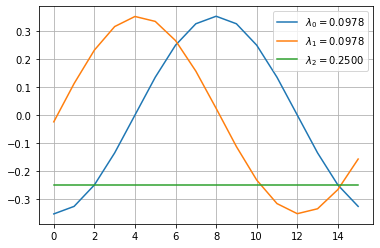

In [430]:
for i in range(3):
    plt.plot(v[:, i], label="$\lambda_{} = {:.4f}$".format(i, lam[i]))
plt.legend();
plt.grid(True);

## 1-Level Method
To generate $K$ examples (i.e., a test matrix $x_{n \times K}$), the 1-level method is the iteration
* $\nu$ Kaczmarz relaxation sweeps on $A x - \lambda x = 0$ with fixed $\lambda$.
* Update $x \longleftarrow x_k / (x_k^T x_k)^{\frac12}$ for all $k$, $\lambda \longleftarrow mean_k((x_k^T A x_k)/(x_k^T x_k))$, where $x_k$ is the $k$th column of $x$.

### Asymptotic Convergence
We start from $x \longleftarrow rand[-1,1], \lambda \longleftarrow 0$ and perform 1-level iterations.

In [431]:
n = 16
kh = 0.5
a = hm.linalg.helmholtz_1d_operator(kh, n)
level = hm.multilevel.Level.create_finest_level(a)
b = np.zeros_like(x)
multilevel = hm.multilevel.Multilevel()
multilevel.level.append(level)

In [432]:
# Run enough Kaczmarz relaxations per lambda update (not just 1 relaxation) so we converge to the minimal one.
num_iters = 10

logger = logging.getLogger("multilevel")
logger.setLevel(logging.DEBUG)

for nu in (1, 5, 10, 100):
    x = hm.multilevel.random_test_matrix((n,), num_examples=10)
    level.global_params.lam = 0
    print("nu {}".format(nu))
    method = lambda x: multilevel.relax_cycle(x, None, None, 1, relax_coarsest=nu)
    x, conv_factor = hm.multilevel.relax_test_matrix(level.operator, level.rq, method, x, num_iters, print_frequency=1)

nu 1
DEBUG        0 |r| 1.44604538e-01 rq -1.49175
DEBUG        1 |r| 2.43012222e-01 (1.68053) rq -1.20624 (0.28551)
DEBUG        2 |r| 1.77743268e-01 (0.73142) rq -1.23229 (0.09122)
DEBUG        3 |r| 1.47083397e-01 (0.82750) rq -1.33919 (4.10450)
DEBUG        4 |r| 1.12062659e-01 (0.76190) rq -1.32164 (0.16419)
DEBUG        5 |r| 1.01071406e-01 (0.90192) rq -1.29593 (1.46462)
DEBUG        6 |r| 9.68417998e-02 (0.95815) rq -1.26093 (1.36145)
DEBUG        7 |r| 9.18404779e-02 (0.94836) rq -1.21996 (1.17068)
DEBUG        8 |r| 8.52962882e-02 (0.92874) rq -1.17760 (1.03385)
DEBUG        9 |r| 7.79545259e-02 (0.91393) rq -1.13768 (0.94224)
DEBUG       10 |r| 7.00163603e-02 (0.89817) rq -1.10202 (0.89336)
nu 5
DEBUG        0 |r| 2.24647367e-01 rq -2.71656
DEBUG        1 |r| 1.17202963e-01 (0.52172) rq -0.29079 (2.42577)
DEBUG        2 |r| 7.36152222e-02 (0.62810) rq -0.20002 (0.03742)
DEBUG        3 |r| 7.00309805e-02 (0.95131) rq -0.17962 (0.22476)
DEBUG        4 |r| 6.71806753e-02 (0.959

It turns out that $\nu$ must be sufficiently large ($100$) to guarantee convergence to the smallest eigenvalue, and even then it depends on the initial guess. This is perhaps because Kaczmarz is a slow relaxation, but more likely because a random initial guess is not good enough. 

Perhaps that's OK; for bootstrapping, we need the initial vectors to be smooth enough, but not necessarily the exact lowest eigenvector.

### Relaxed Test Functions
Now, employ a reasonable number of Kacmzarz sweeps per iteration, and iterations.

In [433]:
num_sweeps = 10
nu = 5

# Generate relaxed test matrix.
level = hm.multilevel.Level.create_finest_level(a)
x = hm.multilevel.random_test_matrix((n,))
b = np.zeros_like(x)
method = lambda x: multilevel.relax_cycle(x, None, None, 1, relax_coarsest=nu)
x, _ = hm.multilevel.relax_test_matrix(level.operator, level.rq, method, x, num_sweeps=num_sweeps)

DEBUG        0 |r| 7.14910645e-02 rq -1.98638
DEBUG        1 |r| 1.06929063e-01 (1.49570) rq -0.01176 (1.97462)
DEBUG        2 |r| 7.38742227e-02 (0.69087) rq 0.00998 (0.01101)
DEBUG        3 |r| 6.86818777e-02 (0.92971) rq 0.00474 (0.24137)
DEBUG        4 |r| 6.68057646e-02 (0.97268) rq 0.00292 (0.34600)
DEBUG        5 |r| 6.52109591e-02 (0.97613) rq 0.00645 (1.94404)
DEBUG        6 |r| 6.32515217e-02 (0.96995) rq 0.01580 (2.64897)
DEBUG        7 |r| 6.08260577e-02 (0.96165) rq 0.03057 (1.57930)
DEBUG        8 |r| 5.79717249e-02 (0.95307) rq 0.04938 (1.27387)
DEBUG        9 |r| 5.48393225e-02 (0.94597) rq 0.07000 (1.09556)
DEBUG       10 |r| 5.16687912e-02 (0.94219) rq 0.08976 (0.95907)


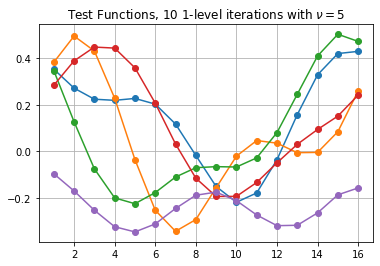

In [434]:
gridpoint = np.arange(1, n+1)
for i in range(5):
    plt.plot(gridpoint, x[:, i], '-o')
plt.grid(True);
plt.title("Test Functions, {} 1-level iterations with $\\nu={}$".format(num_iters, nu));
#plt.savefig("/Users/olivne/Desktop/test_functions.png")

In [435]:
print("Theoretical #points per period {:.2f}".format(2*np.pi/kh))

Theoretical #points per period 12.57


## Coarsening

### Restriction: SVD on Window (Aggregate)
Let $w=4$ be the size of the window. We find $K = 4 w$ relaxed vectors and calculate the SVD of $x[w,:]$. The rows of the restriction $R$ are the principal components that guarantee $10\%$ reconstruction error. 

In [436]:
# Generate coarse variables (R) based on a window of x.
aggregate_size = 4
x_aggregate_t = x[:aggregate_size].transpose()
r, s = hm.restriction.create_restriction(x_aggregate_t, 0.1)

In [437]:
r.asarray()

array([[-0.5 , -0.56, -0.52, -0.4 ],
       [-0.62, -0.21,  0.28,  0.7 ]])

In [438]:
print("Singular values {}".format(s))
print("%unexplained energy / interpolation error {:.3f}".format(
    (sum(s[2:]**2)/sum(s**2))**0.5))

Singular values [3.77 1.79 0.35 0.03]
%unexplained energy / interpolation error 0.084


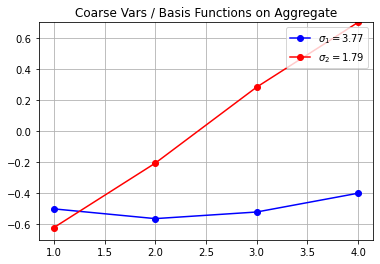

In [439]:
colors = ["b", "r"]
rr = r.asarray()
for i, color in enumerate(colors):
    plt.plot(np.arange(1, aggregate_size + 1), rr[i], '{}o-'.format(color[i  % len(color)]), label="$\sigma_{" + str(i+1) + "} = " + "{:.2f}".format(s[i]) + "$")
plt.ylim([-0.7, 0.7]);
plt.legend(loc="upper right");
plt.grid(True);
plt.title("Coarse Vars / Basis Functions on Aggregate");

<!-- ### Identifying Neighborhoods Algebraically -->

In [440]:
# print("Test Matrix dimension: ", x.shape)

In [441]:
# xt = x.transpose()
# d = sklearn.metrics.pairwise.cosine_similarity(x, x)
# print("(x, x) cos similarity")
# print(d)

For this small $kh$ value, we see that the nearest neighbors are indeed gometric neighbors.

## 2-Level Convergence
Define a bootstrap cycle:
* Relax at the finest level (or perform iterations with the current cycle) on $A x = \lambda  B x$ with $B = I$.
* Construct coarse level: $R$ by SVD and tiling over the entire domain; $P = R^T$; $A^c = R A P$; $B^c = R B P$.

We run two bootstrap cycles.

This gives us a multilevel hierarchy, for which we define an FAS cycle for $A x = \lambda x$. We define $\sigma^0 \equiv 1$ (a vector of size $K$) and $\eta^l(x^l) = (x^l)^T B x^l$.
. At level $l$, it consists of the steps
* If $l = N_{levels}-1$ (coarsest),
  * Repeat $30$ times:
    * Run $5$ Kaczmarz relaxation sweeps on $A x^l - \lambda x^l = b^l$ with fixed $\lambda$.
    * Update $x \longleftarrow x^l_k (\sigma^l_k / \eta^l(x^l))^{\frac12}$ for all $k$, $\lambda \longleftarrow mean_k(((x^l_k)^T (A^l x^l_k - b^l_k))/((x^l_k)^T B^l x^l_k))$, where $x^l_k$ is the $k$th column of $x^l$.
* Else:
  * Relax $\nu_1$ times $A x^l - \lambda B x^l = b^l$.
  * Set $x^{l+1} \longleftarrow R^{l+1} x^l$. Save $x^{l+1}_{INIT} \longleftarrow x^{l+1}$.
  * Set $b^{l+1} \longleftarrow R^{l+1} (b^l - A^l x^l) + A^{l+1} x^{l+1}$.
  * Set $\sigma^{l+1} \longleftarrow \sigma^l - \eta^l(x^l) + \eta^{l+1} x^{l+1}$.
  * Perform $\gamma$ cycles at level $l+1$.
  * Correct $x^l \longleftarrow x^l + P(x^{l+1} - x^{l+1}_{INIT})$.
  * Relax $\nu_2$ times $A x^l - \lambda B x^l = b^l$.
  
Note how we keep a single $\lambda$ value for all test functions and update it to the mean Rayleigh quotient at the coarsest level.

### Example where things go well

In [442]:
np.random.seed(0)
x, multilevel = hm.bootstrap.generate_test_matrix(a, 0, num_examples=8, num_bootstrap_steps=2)
assert len(multilevel) == 2

# FMG start so (x, lambda) has a reasonable initial guess.
level = multilevel.level[0]
x_init = hm.bootstrap.fmg(multilevel, num_cycles_finest=0)

# Check that (3,3) is at least as fast as (3,2). Print conv factor vs. nu1, nu2.
# x, lam = exact_eigenpair(multilevel.level[0].a)
# x = x[:, None]
# multilevel.level[0].global_params.lam = lam

INFO     Smallest domain size 16, bootstrap with 2 levels
INFO     Bootstrap step 1/2
INFO     Relax at level 0
DEBUG        0 |r| 2.24984631e-01 rq -2.24869
DEBUG        1 |r| 9.95735154e-02 (0.44258) rq -0.18450 (2.06418)
DEBUG        2 |r| 6.35658256e-02 (0.63838) rq -0.12729 (0.02772)
DEBUG        3 |r| 5.93875730e-02 (0.93427) rq -0.10377 (0.41111)
DEBUG        4 |r| 5.77404041e-02 (0.97226) rq -0.08118 (0.96045)
DEBUG        5 |r| 5.60453917e-02 (0.97064) rq -0.05621 (1.10536)
DEBUG        6 |r| 5.32752653e-02 (0.95057) rq -0.02917 (1.08275)
DEBUG        7 |r| 4.92178672e-02 (0.92384) rq -0.00173 (1.01517)
DEBUG        8 |r| 4.40458167e-02 (0.89492) rq 0.02397 (0.93605)
DEBUG        9 |r| 3.81383349e-02 (0.86588) rq 0.04597 (0.85645)
DEBUG       10 |r| 3.19918685e-02 (0.83884) rq 0.06322 (0.78375)
INFO     lambda 0.07341871151593471
INFO     Coarsening level 0->1
DEBUG    Singular vals [1.54 0.61 0.09 0.01], nc 2 interpolation error 0.052
INFO     Relax at level 1
DEBUG        0 

In [443]:
print("R on aggregate")
print(multilevel.level[1].r.asarray())
print("A^c")
print(multilevel.level[1].a.toarray())

R on aggregate
[[-0.53 -0.56 -0.51 -0.38]
 [-0.61 -0.17  0.29  0.71]]
A^c
[[-0.19 -0.11  0.2   0.23  0.    0.    0.2  -0.38]
 [-0.11 -1.22 -0.38 -0.44  0.    0.    0.23 -0.44]
 [ 0.2  -0.38 -0.19 -0.11  0.2   0.23  0.    0.  ]
 [ 0.23 -0.44 -0.11 -1.22 -0.38 -0.44  0.    0.  ]
 [ 0.    0.    0.2  -0.38 -0.19 -0.11  0.2   0.23]
 [ 0.    0.    0.23 -0.44 -0.11 -1.22 -0.38 -0.44]
 [ 0.2   0.23  0.    0.    0.2  -0.38 -0.19 -0.11]
 [-0.38 -0.44  0.    0.    0.23 -0.44 -0.11 -1.22]]


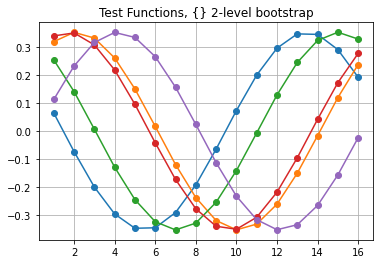

In [444]:
gridpoint = np.arange(1, n+1)
for i in range(5):
    plt.plot(gridpoint, x[:, i], '-o')
plt.grid(True);
plt.title("Test Functions, {} 2-level bootstrap");
#plt.savefig("/Users/olivne/Desktop/test_functions.png")

### Stationarity Test
Starting from exact solution, the cycle doesn't change the residuals, whether the relaxations are applied before or after the coarse-level correction during the cycle.

In [445]:
# Stationarity test of Cycle(0, 2).
x = v[:, :1]
multilevel.level[0].global_params.lam = lam[0]
multilevel.relax_cycle(x, 0, 2, 30, update_lam="coarsest", debug=True);

# Stationarity test of Cycle(2, 0).
x = v[:, :1]
multilevel.level[0].global_params.lam = lam[0]
multilevel.relax_cycle(x, 2, 0, 30, update_lam="coarsest", debug=True);

DEBUG    --------------------------------------------------------------------------------
DEBUG    Level    Operation          |R|           |R_norm|      lambda    
DEBUG    0        initial            5.7371e-16    0.0000e+00    0.09775907
DEBUG    1        initial            4.4928e-16    0.0000e+00    0.09775907
DEBUG    1        coarsest (30)      3.1281e-17    2.2204e-16    0.09775907
DEBUG    0        correction 0       3.5336e-16    2.2204e-16    0.09775907
DEBUG    0        relax 2            1.0200e-16    0.0000e+00    0.09775907
DEBUG    --------------------------------------------------------------------------------
DEBUG    Level    Operation          |R|           |R_norm|      lambda    
DEBUG    0        initial            3.5819e-16    2.2204e-16    0.09775907
DEBUG    0        relax 2            1.1741e-16    0.0000e+00    0.09775907
DEBUG    1        initial            1.0723e-16    0.0000e+00    0.09775907
DEBUG    1        coarsest (30)      6.0426e-17    1.1102e-1

### Asymptotic Convergence vs. $\nu_1 + \nu_2$
We test both $Cycle(0,\nu)$ and $Cycle(\nu,0)$ for $\nu=1,\dots,8$. We expect that
* The asymptotic convergence of both cycles is the same.
* The convergence improves with $\nu$, up to a point (bounded by the interpolation/coarse-level correction accuracy).

In [446]:
logger = logging.getLogger("multilevel")
logger.setLevel(logging.INFO)

def two_level_conv_factor(nu1, nu2):
    logger.debug("nu1 {} nu2 {}".format(nu1, nu2))
    relax_cycle = lambda x: multilevel.relax_cycle(x, nu1, nu2, 10, update_lam="coarsest")
    x = x_init.copy()
    x, conv_factor = hm.multilevel.relax_test_matrix(
        level.operator, level.rq, relax_cycle, x, 10,
        residual_stop_value=1e-11, lam_stop_value=1e-20)
    return conv_factor


conv_factor = pd.DataFrame([
    [two_level_conv_factor(nu1, nu2) for nu2 in range(6)]
    for nu1 in range(6)])

Two-level convergence factor (measured over the last 5 cycles) vs. $\nu_1$ (down), $\nu_2$ (across):

In [447]:
conv_factor

,0,1,2,3,4,5
0,1.000000,0.486409,0.311367,0.388732,0.288462,0.233796
1,0.439378,0.315011,0.409524,0.370380,0.338014,0.324218
2,0.327383,0.410182,0.369318,0.337836,0.324206,0.304168
3,0.409833,0.370840,0.336556,0.324180,0.304161,0.285133
4,0.370347,0.337560,0.324108,0.304171,0.285136,0.268163
5,0.338198,0.324227,0.304207,0.285138,0.268166,0.250895


The convergence factor depends only on $\nu_1+\nu_2$ and improves with $\nu_1+\nu_2$, up to $0.2$. For an interpolation error of $\varepsilon$, if a fine-operator eigenvector's eigenvalue is $\lambda$ and the corresponding coarse-operator eigenvalue os $lam^c$, we can expect a coarse-level correction error $\approx 1 - (1-\varepsilon)^2 (\lambda^c/\lambda)$. The experimental result is close to this rule-of-thumb estimation.

In [448]:
lam1 = eig(multilevel.level[1].a.toarray())[0]
lam1 = lam1[np.argsort(np.abs(lam1))]
print("Fine lam (smallest 8)", lam[:8])
print("Coarse lam           ", lam1)
print("Ratio                ", lam1 / lam[:8])

Fine lam (smallest 8) [ 0.1   0.1   0.25 -0.34 -0.34 -0.98 -0.98 -1.75]
Coarse lam            [ 0.1   0.1   0.24 -0.34 -0.6  -1.51 -1.51 -2.12]
Ratio                 [1.   1.   0.95 1.03 1.79 1.54 1.54 1.21]


In [449]:
print("Rule of thumb lower bound for coarse level operator's convergence of smooth components {:.2f}".format(1 - (1 - 0.095)**2 * 1.03))

Rule of thumb lower bound for coarse level operator's convergence of smooth components 0.16


### Case of Random Start that Leads to Bad Multilevel Hierarchy
Problem: the quality of the multilevel hierarchy (2-level convergence factors) depends on the random start of the bootstrap process. Here's an example where things go badly.

In [450]:
np.random.seed(1)
x, multilevel = hm.bootstrap.generate_test_matrix(a, 0, num_examples=8, num_bootstrap_steps=2)
assert len(multilevel) == 2

# FMG start so (x, lambda) has a reasonable initial guess.
level = multilevel.level[0]
x_init = hm.bootstrap.fmg(multilevel, num_cycles_finest=0)

# Check that (3,3) is at least as fast as (3,2). Print conv factor vs. nu1, nu2.
# x, lam = exact_eigenpair(multilevel.level[0].a)
# x = x[:, None]
# multilevel.level[0].global_params.lam = lam

INFO     Smallest domain size 16, bootstrap with 2 levels
INFO     Bootstrap step 1/2
INFO     Relax at level 0
INFO     lambda -0.31917509927168974
INFO     Coarsening level 0->1
DEBUG    Singular vals [1.13 0.91 0.05 0.  ], nc 2 interpolation error 0.037
INFO     Relax at level 1
INFO     lambda -0.31917509927168974
INFO     Bootstrap step 2/2
INFO     Cycle at level 0
INFO     lambda -0.3357864366442618
INFO     Coarsening level 0->1
DEBUG    Singular vals [1.03e+00 9.71e-01 1.82e-07 1.76e-10], nc 2 interpolation error 0.000
INFO     Relax at level 1
INFO     lambda -0.3357864366442618
DEBUG    FMG level 1 init |r| 3.25091825e-01 lam 0.00000
DEBUG    FMG level 1 cycles 1 |r| 1.49306020e-01 lam -0.07718
DEBUG    FMG level 0 init |r| 1.49306020e-01 lam -0.07718
DEBUG    FMG level 0 cycles 0 |r| 1.49306020e-01 lam -0.07718


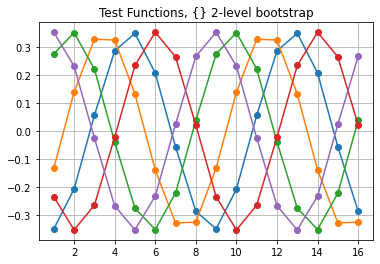

In [451]:
gridpoint = np.arange(1, n+1)
for i in range(5):
    plt.plot(gridpoint, x[:, i], '-o')
plt.grid(True);
plt.title("Test Functions, {} 2-level bootstrap");
#plt.savefig("/Users/olivne/Desktop/test_functions.png")

In [452]:
conv_factor = pd.DataFrame([
    [two_level_conv_factor(nu1, nu2) for nu2 in range(6)]
    for nu1 in range(6)])
conv_factor

,0,1,2,3,4,5
0,1.000000,0.855511,0.690310,0.774676,1.495683,1.027762
1,0.835846,0.622564,0.587760,0.594010,0.593649,0.589599
2,0.749383,0.651336,0.647895,0.660666,0.675322,0.691218
3,1.288604,1.499193,1.937037,1.140961,1.746367,1.301663
4,0.780992,0.724863,0.740150,0.780788,0.815673,0.836449
5,0.750905,0.730700,0.751454,0.783219,0.804384,0.815843


In [453]:
print("R on aggregate")
print(multilevel.level[1].r.asarray())
print("A^c")
print(multilevel.level[1].a.toarray())

R on aggregate
[[ 0.32  0.67  0.63  0.22]
 [-0.63 -0.22  0.32  0.67]]
A^c
[[-0.2   0.08  0.07 -0.14  0.    0.    0.07  0.22]
 [ 0.08 -1.18  0.22 -0.42  0.    0.   -0.14 -0.42]
 [ 0.07  0.22 -0.2   0.08  0.07 -0.14  0.    0.  ]
 [-0.14 -0.42  0.08 -1.18  0.22 -0.42  0.    0.  ]
 [ 0.    0.    0.07  0.22 -0.2   0.08  0.07 -0.14]
 [ 0.    0.   -0.14 -0.42  0.08 -1.18  0.22 -0.42]
 [ 0.07 -0.14  0.    0.    0.07  0.22 -0.2   0.08]
 [ 0.22 -0.42  0.    0.   -0.14 -0.42  0.08 -1.18]]


In [454]:
logger = logging.getLogger("multilevel")
logger.setLevel(logging.DEBUG)

nu1 = 0
nu2 = 4
logger.debug("nu1 {} nu2 {}".format(nu1, nu2))
relax_cycle = lambda x: multilevel.relax_cycle(x, nu1, nu2, 10, update_lam="coarsest")
x = x_init.copy()
x, conv_factor = hm.multilevel.relax_test_matrix(
    level.operator, level.rq, relax_cycle, x, 20,
    residual_stop_value=1e-11, lam_stop_value=1e-20)
print("Asymptotic Convergence Factor {:.2f}".format(conv_factor))

DEBUG    nu1 0 nu2 4
DEBUG        0 |r| 1.69321750e-01 rq -0.07718
DEBUG        2 |r| 1.22790417e-02 (0.24249) rq 0.09718 (0.10689)
DEBUG        4 |r| 1.28516642e-03 (0.69520) rq 0.09789 (0.17322)
DEBUG        6 |r| 4.86765388e-03 (1.96230) rq 0.09971 (3.89802)
DEBUG        8 |r| 1.60397787e-02 (1.72765) rq 0.12285 (3.25953)
DEBUG       10 |r| 1.98769893e-02 (0.92064) rq 0.20718 (1.14357)
DEBUG       12 |r| 8.39992537e-03 (0.61653) rq 0.24406 (0.40309)
DEBUG       14 |r| 2.95920873e-03 (0.58988) rq 0.24926 (0.35449)
DEBUG       16 |r| 1.01843848e-03 (0.58609) rq 0.24991 (0.34992)
DEBUG       18 |r| 3.48535345e-04 (0.58464) rq 0.24999 (0.34591)
DEBUG       20 |r| 1.18619908e-04 (0.58293) rq 0.25000 (0.34076)
Asymptotic Convergence Factor 0.58


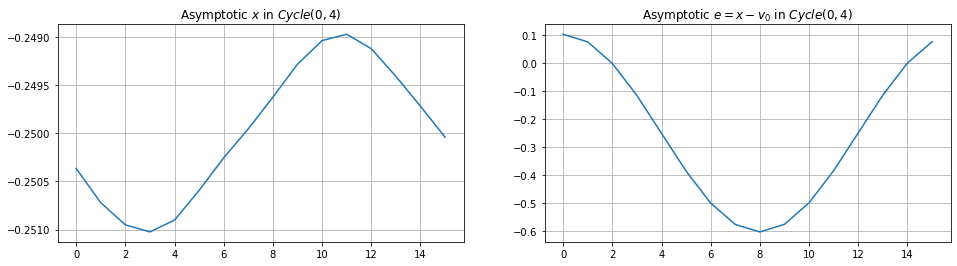

In [455]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

ax = axs[0]
ax.plot(x[:, 0])
ax.set_title("Asymptotic $x$ in $Cycle({},{})$".format(nu1, nu2));
ax.grid(True);

ax = axs[1]
ax.plot(x[:, 0] - v[:, 0])
ax.set_title("Asymptotic $e = x - v_0$ in $Cycle({},{})$".format(nu1, nu2));
ax.grid(True);

Looks like the convergence factor was estimated on too few cycles; with more, we see convergence, but not the smallest $\lambda$, and it takes many cycles to find the right nonlinear solution. This must be an initial guess issue.
* The coarse operator and $R$ don't seem much different than the "good" run.
* Probably because the test functions are not smooth enough.
* Note that the asymptotic $x$ contains a large constant component here.

How can we improve the initial guess to the bootstrap process to avoid this?

## 3-Level Convergence

Generally, the bootstrap cycle is defined by
* Run $10$ iterations of. One-level method (or perform iterations with the current $Cycle(2, 2)$) $10$ times at the finest level $l=0$ on $A x = \lambda x$ to obtain $x^0$.
* For $l = 1,\dots,N_{levels}$, 
  * Construct coarse level $l$: $R$ by SVD and tiling over the entire domain; $P = R^T$; $A^c = R A P$.
  * $x^l \longleftarrow R x^{l-1}$.
  * Relax on $A^l x = \lambda^l x$ to improve $x^l$.
  
We perfom two bootstrap cycles, starting from $x = rand[-1,1]$ and $\lambda=0$.

In [456]:
np.random.seed(4)
x, multilevel = hm.bootstrap.generate_test_matrix(a, 0, num_sweeps=10, num_examples=20, num_bootstrap_steps=1,
                                                  initial_max_levels=3)
assert len(multilevel) == 3

level = multilevel.level[0]

INFO     Smallest domain size 16, bootstrap with 3 levels
INFO     Bootstrap step 1/1
INFO     Relax at level 0
DEBUG        0 |r| 9.60321446e-02 rq -1.42763
DEBUG        1 |r| 8.23674151e-02 (0.85771) rq 0.03026 (1.45790)
DEBUG        2 |r| 5.43821871e-02 (0.66024) rq 0.04992 (0.01348)
DEBUG        3 |r| 4.90184673e-02 (0.90137) rq 0.05262 (0.13726)
DEBUG        4 |r| 4.65434169e-02 (0.94951) rq 0.05576 (1.16608)
DEBUG        5 |r| 4.45063206e-02 (0.95623) rq 0.05955 (1.20263)
DEBUG        6 |r| 4.23612981e-02 (0.95180) rq 0.06383 (1.13310)
DEBUG        7 |r| 3.99406499e-02 (0.94286) rq 0.06845 (1.07725)
DEBUG        8 |r| 3.71652664e-02 (0.93051) rq 0.07321 (1.03007)
DEBUG        9 |r| 3.39919625e-02 (0.91462) rq 0.07790 (0.98667)
DEBUG       10 |r| 3.04271891e-02 (0.89513) rq 0.08233 (0.94255)
INFO     lambda -0.0010000106137099869
INFO     Coarsening level 0->1
DEBUG    Singular vals [1.75 0.9  0.27 0.02], nc 3 interpolation error 0.008
INFO     Relax at level 1
DEBUG        0 |r| 

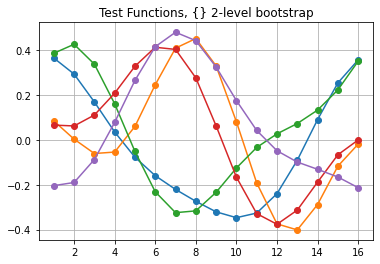

In [457]:
gridpoint = np.arange(1, n+1)
for i in range(5):
    plt.plot(gridpoint, x[:, i], '-o')
plt.grid(True);
plt.title("Test Functions, {} 2-level bootstrap");
#plt.savefig("/Users/olivne/Desktop/test_functions.png")

### V(2,2) Convergence Speed Test
We start cycling from an FMG start so $(x, \lambda)$ has a reasonable initial guess.

In [458]:
# Convergence speed test.
# FMG start so (x, lambda) has a reasonable initial guess.
x_init = hm.bootstrap.fmg(multilevel, num_cycles_finest=0, num_cycles=1)

relax_cycle = lambda x: multilevel.relax_cycle(x, 2, 2, 100, max_levels=3)
x, conv_factor = hm.multilevel.relax_test_matrix(level.operator, level.rq, relax_cycle, x_init, 15)
print("Asymptotic Convergence Factor {:.2f}".format(conv_factor))

DEBUG    FMG level 2 init |r| 6.86448603e-01 lam 0.00000
DEBUG    FMG level 2 cycles 1 |r| 3.92646391e-02 lam 0.09455
DEBUG    FMG level 1 init |r| 3.92646391e-02 lam 0.09455
DEBUG    FMG level 1 cycles 1 |r| 1.62249817e-02 lam 0.09666
DEBUG    FMG level 0 init |r| 1.62249817e-02 lam 0.09666
DEBUG    FMG level 0 cycles 0 |r| 1.62249817e-02 lam 0.09666
DEBUG        0 |r| 1.62249817e-02 rq 0.09753
DEBUG        1 |r| 5.67217221e-03 (0.34959) rq 0.09781 (0.00027)
DEBUG        2 |r| 1.98757889e-03 (0.35041) rq 0.09778 (0.09834)
DEBUG        3 |r| 7.66525089e-04 (0.38566) rq 0.09776 (0.66505)
DEBUG        4 |r| 2.90197626e-04 (0.37859) rq 0.09776 (0.11570)
DEBUG        5 |r| 1.10324704e-04 (0.38017) rq 0.09776 (0.15560)
DEBUG        6 |r| 4.18928657e-05 (0.37972) rq 0.09776 (0.14060)
DEBUG        7 |r| 1.59140251e-05 (0.37987) rq 0.09776 (0.14566)
DEBUG        8 |r| 6.04448552e-06 (0.37982) rq 0.09776 (0.14376)
DEBUG        9 |r| 2.29594193e-06 (0.37984) rq 0.09776 (0.14447)
DEBUG       10 |

The asymptotic convergence factor isn't bad, and is close to the two-level factor. But again, notice how during the bootstrap run, the obtained $\lambda$ value is not the smallest in absolute value of $A$.